# Predicción de Tráfico de Internet con ST-GNN DenseNet

## Descripción del Problema
Este notebook implementa un modelo de aprendizaje profundo para predecir el **volumen de tráfico de Internet (Datos)** en telecomunicaciones.
El objetivo es predecir la demanda futura en función del historial reciente y del contexto espacial (vecinos) y temporal (hora/día).

## Datos y Unidades
*   **Fuente**: CDRs (Call Detail Records) agregados.
*   **Variable Objetivo**: Volumen de tráfico de Internet.
*   **Unidades**: Los datos están normalizados utilizando **Z-Score (Standardization)**.
    *   Valor 0: Media del tráfico.
    *   Valor +1: 1 Desviación Estándar por encima de la media.
    *   Valor -1: 1 Desviación Estándar por debajo de la media.
    *   **Nota**: Las gráficas muestran estos valores normalizados (o des-normalizados si se aplica la inversa). En la evaluación final se des-normalizan a las unidades originales (Volumen Agregado).

## Arquitectura: ST-GNN DenseNet
Este modelo combina tres componentes clave:
1.  **Embeddings Temporales**: Aprende representaciones vectoriales para la Hora del día (0-23) y el Día de la semana (0-6).
2.  **Dense Spatial Block (GAT)**:
    *   Usa **Graph Attention Networks (GAT)** para capturar relaciones espaciales entre celdas vecinas.
    *   **Vectorización**: Procesa todo el batch como un "Super-Grafo" desconectado para máxima velocidad en GPU.
    *   **Dense Connections**: Cada capa recibe la concatenación de *todas* las capas anteriores (similar a DenseNet), mejorando el flujo de gradientes y el reuso de características.
3.  **Componente Temporal (GRU)**:
    *   Usa una **Gated Recurrent Unit (GRU)** para modelar la secuencia temporal de cada nodo.
    *   Más eficiente y rápida que LSTM.

## Optimizaciones de Memoria (VRAM)
Para entrenar este modelo complejo en GPU limitada:
*   **Gradient Accumulation**:
    *   `BATCH_SIZE` físico: **8** (Lo que cabe en VRAM).
    *   `ACCUMULATION_STEPS`: **4**.
    *   `BATCH_SIZE` efectivo: **32** (Equivalente matemático).
    *   Esto permite entrenar modelos grandes sin errores de memoria (OOM).


In [1]:
import torch.nn.functional as F
import sys
try:
    import dask
    import dask.dataframe as dd
    print(f"Dask version: {dask.__version__}")
    print("Dask dataframe imported successfully.")
except ImportError as e:
    print(f"Error importing dask: {e}")
    sys.exit(1)

try:
    import torch
    print(f"Torch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
except ImportError as e:
    print(f"Error importing torch: {e}")


Dask version: 2025.11.0
Dask dataframe imported successfully.
Torch version: 2.9.1+cu128
CUDA available: True


# Documentación del Modelo de Predicción de Tráfico (ST-DenseNet)

Este documento detalla la arquitectura, formulación matemática y metodología utilizada en el modelo de predicción de tráfico celular (Internet) para la ciudad de Milán. El modelo se basa en una arquitectura **ST-DenseNet** (Spatio-Temporal Densely Connected Convolutional Network).

## 1. Definición del Problema

El objetivo es predecir el volumen de tráfico de Internet (entrante y saliente) para cada celda de una cuadrícula de $100 \times 100$ en la ciudad de Milán para el siguiente intervalo de tiempo, basándose en datos históricos.

Sea $X_t \in \mathbb{R}^{2 \times 100 \times 100}$ el tensor de tráfico en el tiempo $t$, donde el canal 0 representa `internetin` y el canal 1 representa `internetout`. El objetivo es aprender una función $f$ tal que:

$$ \hat{X}_{t} = f(X_{t-1}, X_{t-2}, \dots, X_{t-n}) $$

In [2]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuración del Dispositivo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Parámetros del Modelo
H, W = 100, 100  # Dimensiones de la cuadrícula
LEN_CLOSE = 3    # Dependencia de proximidad (p)
LEN_PERIOD = 3   # Dependencia de periodo (q)
NB_FLOW = 1      # Canales (Internet In, Internet Out)

# Parámetros de Entrenamiento
BATCH_SIZE = 8  # Reduced for VRAM (Accumulate to 32)
EPOCHS = 100
LEARNING_RATE = 0.01

Usando dispositivo: cuda
GPU: NVIDIA GeForce RTX 5080


## 2. Preprocesamiento de Datos

### 2.1. Agregación Espacio-Temporal
Los datos se agregan espacialmente en una rejilla de $(H 	imes W)$ y temporalmente en intervalos de 1 hora.

### 2.2. Normalización Z-Score (Estandarización)
Sí, la **Z-Score** es mejor para este tipo de datos porque el tráfico de Internet suele tener distribuciones con colas largas (picos de uso) y outliers. La estandarización centra los datos en 0 y escala la varianza a 1, lo que ayuda a la red neuronal a converger más rápido y manejar mejor los valores atípicos que Min-Max (que comprime todo el rango si hay un outlier muy grande).

La transformación aplicada es:

$$ X_{norm} = \frac{X - \mu}{\sigma + \epsilon} $$

Donde:
*   $X$: Valor de tráfico original (Volumen).
*   $\mu$: Media global del conjunto de entrenamiento.
*   $\sigma$: Desviación estándar del conjunto de entrenamiento.

Esto resulta en valores centrados en 0, donde valores positivos indican tráfico por encima de la media y negativos por debajo.


### 2.1. Construcción del Grafo (Grid to Graph)
Convertimos la rejilla de 100x100 en un grafo donde cada celda es un nodo conectado a sus vecinos (arriba, abajo, izquierda, derecha).

In [3]:

import scipy.sparse as sp

# --- CONSTRUCCIÓN DEL GRAFO (SPARSE / EDGE INDEX) ---
def get_edge_index(h, w):
    rows = []
    cols = []
    for r in range(h):
        for c in range(w):
            idx = r * w + c
            # Vecinos: arriba, abajo, izq, der
            if r > 0: 
                rows.append((r-1)*w + c); cols.append(idx)
            if r < h-1: 
                rows.append((r+1)*w + c); cols.append(idx)
            if c > 0: 
                rows.append(r*w + c - 1); cols.append(idx)
            if c < w-1: 
                rows.append(r*w + c + 1); cols.append(idx)
                
    # Retornamos Tensor [2, E]
    edge_index = torch.tensor([rows, cols], dtype=torch.long)
    return edge_index

print("Construyendo lista de aristas (Sparse edge_index)...")
edge_index = get_edge_index(100, 100).to(DEVICE)
print(f"Edge Index Shape: {edge_index.shape}") # [2, ~40000]


Construyendo lista de aristas (Sparse edge_index)...
Edge Index Shape: torch.Size([2, 39600])


### 2.2. Normalización Z-Score


In [4]:
files = ['../data1.csv/data1.csv', '../data2.csv/data2.csv']
valid_files = [f for f in files if os.path.exists(f)]

print("Cargando y agregando datos (esto puede tardar)...")

# Cargar con Dask
ddf = dd.read_csv(valid_files, assume_missing=True)

# Convertir TimeInterval a datetime
ddf['Timestamp'] = dd.to_datetime(ddf['TimeInterval'], unit='ms')

# Redondear a la hora (Agregación Temporal)
ddf['Hour'] = ddf['Timestamp'].dt.floor('h')

# Seleccionar columnas de interés (Internet)
cols = ['Hour', 'GridID', 'internet']
ddf = ddf[cols]

# Agrupar por Hora y GridID
agg_task = ddf.groupby(['Hour', 'GridID'])[['internet']].sum()

with ProgressBar():
    df_agg = agg_task.compute().reset_index()

print("Agregación completada.")
print(df_agg.head())

Cargando y agregando datos (esto puede tardar)...
[########################################] | 100% Completed | 64.94 s
Agregación completada.
                 Hour  GridID    internet
0 2013-12-23 23:00:00   435.0   48.830392
1 2013-12-23 23:00:00   490.0    7.934888
2 2013-12-23 23:00:00   538.0   88.340195
3 2013-12-23 23:00:00   546.0  128.755505
4 2013-12-23 23:00:00   578.0   49.262224


In [5]:
# --- CONSTRUCCIÓN DE LA MATRIZ 4D (Time, Channels, H, W) ---

# Filtrar GridIDs válidos (1 a 10000)
df_agg = df_agg[(df_agg['GridID'] >= 1) & (df_agg['GridID'] <= 10000)]

# Crear índice temporal completo
min_time = df_agg['Hour'].min()
max_time = df_agg['Hour'].max()
time_range = pd.date_range(min_time, max_time, freq='H')

print(f"Rango temporal: {min_time} a {max_time} ({len(time_range)} horas)")

# Inicializar tensor gigante: [Time, 2, 100, 100]
data_tensor = np.zeros((len(time_range), 1, 100, 100), dtype=np.float32)

# Mapeo de tiempo a índice
time_to_idx = {t: i for i, t in enumerate(time_range)}

print("Rellenando tensor 4D...")
# Iterar y rellenar (esto puede ser lento en Python puro, pero pandas lo facilita)
# Pivotar tabla para tener GridID como columnas
df_pivot = df_agg.pivot_table(index='Hour', columns='GridID', values=['internet'], fill_value=0)

# Rellenar el tensor
for t in time_range:
    if t in df_pivot.index:
        idx = time_to_idx[t]
        # internet
        vals = df_pivot.loc[t, 'internet'].reindex(range(1, 10001), fill_value=0).values
        data_tensor[idx, 0, :, :] = vals.reshape(100, 100)
print(f"Tensor shape: {data_tensor.shape}")
# --- RESHAPE FOR GNN [Time, Nodes, Features] ---
N = H * W
data_gnn = data_tensor.reshape(-1, N, 1) # [Time, 10000, 1]
print(f'GNN Data Shape (Time, Nodes, Feat): {data_gnn.shape}')


Rango temporal: 2013-10-31 23:00:00 a 2014-01-01 22:00:00 (1488 horas)
Rellenando tensor 4D...
Tensor shape: (1488, 1, 100, 100)
GNN Data Shape (Time, Nodes, Feat): (1488, 10000, 1)


In [6]:

# --- NORMALIZACIÓN Z-SCORE ---
traffic_mean = data_gnn.mean()
traffic_std = data_gnn.std()
print(f"Mean: {traffic_mean}, Std: {traffic_std}")

data_norm = (data_gnn - traffic_mean) / traffic_std
print(f"Min norm: {data_norm.min()}, Max norm: {data_norm.max()}")
             

Mean: 373.1783447265625, Std: 723.292724609375
Min norm: -0.515943706035614, Max norm: 55.13580322265625


### 2.3. Construcción de Entradas (Dependencias Temporales)
El modelo captura dos tipos de dependencias temporales:

1.  **Cercanía (Closeness - $X_c$)**: Captura la tendencia reciente. Se toman los últimos $l_c$ intervalos de tiempo.
    $$ X_c = [X_{t-l_c}, X_{t-(l_c-1)}, \dots, X_{t-1}] $$
    
2.  **Periodo (Period - $X_d$)**: Captura la periodicidad diaria (mismo hora del día en días anteriores). Se toman $l_p$ días.
    $$ X_d = [X_{t-l_p \cdot 24}, X_{t-(l_p-1) \cdot 24}, \dots, X_{t-24}] $$

In [7]:

# --- FAILSAFE FOR VARIABLES ---
import pandas as pd
import numpy as np

if 'time_feat_np' not in locals():
    print("WARNING: time_feat_np was missing. Attempting auto-reconstruction...")
    if 'time_range' not in locals():
        if 'df_agg' in locals():
            print("Reconstructing time_range from df_agg...")
            _min_t = df_agg['Hour'].min()
            _max_t = df_agg['Hour'].max()
            time_range = pd.date_range(_min_t, _max_t, freq='H')
        else:
            print("ERROR: df_agg is also missing. Please run the Data Loading cell (Section 2.1)!")
            
    if 'time_range' in locals():
        time_feat_np = np.stack([time_range.hour, time_range.dayofweek], axis=1)
        print(f"time_feat_np reconstructed. Shape: {time_feat_np.shape}")


#  GENERACIÓN DE DATASET

def create_gnn_dataset_optimized(data, time_data, len_c, len_p):
    # data: [Time, Nodes, Features]
    # time_data: [Time, 2] (Hour, Day)
    T, N, F = data.shape
    
    X, Time_Seq, Y = [], [], []
    
    start_idx = max(len_c, len_p * 24)
    
    print("Generando dataset GNN con Tiempo...")
    for i in range(start_idx, T):
        y = data[i] 
        
        # Sequence indices
        # Closeness
        idx_c = np.arange(i-len_c, i)
        
        # Period
        idx_p = []
        for p in range(len_p, 0, -1):
            idx_p.append(i - (p * 24))
        
        full_idx = np.concatenate([idx_p, idx_c]) # [Seq_Len]
        
        x_seq = data[full_idx] # [Seq_Len, N, F]
        t_seq = time_data[full_idx] # [Seq_Len, 2]
        
        X.append(x_seq)
        Time_Seq.append(t_seq)
        Y.append(y)
        
    return np.array(X), np.array(Time_Seq), np.array(Y)

print("Generando tensores X, T, Y...")
X, T_seq, Y = create_gnn_dataset_optimized(data_norm, time_feat_np, LEN_CLOSE, LEN_PERIOD)
print(f"X shape: {X.shape}, T shape: {T_seq.shape}")
            

time_feat_np reconstructed. Shape: (1488, 2)
Generando tensores X, T, Y...
Generando dataset GNN con Tiempo...
X shape: (1416, 6, 10000, 1), T shape: (1416, 6, 2)


In [8]:

# --- DIVISIÓN TRAIN / TEST ---
test_hours = 7 * 24
total_samples = len(Y)
train_samples = total_samples - test_hours

X_train, T_train, Y_train = X[:train_samples], T_seq[:train_samples], Y[:train_samples]
X_test, T_test, Y_test = X[train_samples:], T_seq[train_samples:], Y[train_samples:]

# Dataset includes time now
train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(T_train).long(), torch.from_numpy(Y_train).float())
test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(T_test).long(), torch.from_numpy(Y_test).float())

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
             


## 3. Arquitectura del Modelo: ST-GNN (Spatio-Temporal Graph Neural Network)

El modelo combina **Convoluciones en Grafos (GCN)** para capturar dependencias espaciales y **LSTM** para dependencias temporales.

1.  **GCN Layer**: Procesa la información espacial usando la matriz de adyacencia.
    $$ H' = \sigma(\hat{A} H W) $$
2.  **LSTM Layer**: Procesa la secuencia temporal de características extraídas por la GCN para cada nodo.
3.  **Output Layer**: Predicción final para cada nodo.
             


## 3. Arquitectura Optimizada: Time-Aware ST-GAT
Se introducen mejoras significativas:
1.  **Time Embeddings**: Capas de embedding para Hora y Día, concatenadas a las features de cada nodo.
2.  **GAT Layer**: Atención gráfica para ponderar vecinos dinámicamente. 
    *Nota: Se itera sobre el batch para evitar problemas de memoria (OOM) con grafos densos.*
             

In [9]:

import torch.nn.functional as F

# Reusing GATLayer from Turbo (it should be defined in previous cell or same)
# We will redefine it just to be safe and self-contained or rely on existing execution order?
# Better redefine to ensure it matches expectations.

class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, alpha=0.2):
        super(GATLayer, self).__init__()
        self.W = nn.Linear(in_features, out_features, bias=False)
        self.a_l = nn.Linear(out_features, 1, bias=False)
        self.a_r = nn.Linear(out_features, 1, bias=False)
        self.leakyrelu = nn.LeakyReLU(alpha)

    def forward(self, x, edge_index):
        # x: [TotalNodes, In]
        Wh = self.W(x) 
        f_l = self.a_l(Wh)
        f_r = self.a_r(Wh)
        
        row, col = edge_index[0], edge_index[1]
        e = self.leakyrelu(f_l[row] + f_r[col]).squeeze(-1)
        
        e_exp = torch.exp(e)
        node_sum_exp = torch.zeros(x.size(0), device=x.device, dtype=e_exp.dtype)
        node_sum_exp.index_add_(0, col, e_exp)
        
        alpha = e_exp / (node_sum_exp[col] + 1e-10)
        
        weighted_src = alpha.unsqueeze(-1) * Wh[row]
        
        out = torch.zeros_like(Wh)
        weighted_src = weighted_src.to(out.dtype) # AMP Cast
        out.index_add_(0, col, weighted_src)
        
        return F.elu(out)

class DenseGATBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseGATBlock, self).__init__()
        self.layers = nn.ModuleList()
        current_dim = in_channels
        
        for i in range(num_layers):
            # Each layer takes everything before it
            self.layers.append(GATLayer(current_dim, growth_rate))
            current_dim += growth_rate
            
    def forward(self, x, edge_index):
        # x: [TotalNodes, In]
        features = [x]
        
        for layer in self.layers:
            # Concat all previous features
            in_feat = torch.cat(features, dim=1)
            out = layer(in_feat, edge_index)
            features.append(out)
            
        # Return all features concatenated? Or just the concatenation of inputs + outputs?
        return torch.cat(features, dim=1)

class TimeAwareDenseSTGNN(nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels, seq_len, growth_rate=32, num_dense_layers=3):
        super(TimeAwareDenseSTGNN, self).__init__()
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        
        self.emb_hour = nn.Embedding(24, 8) 
        self.emb_day = nn.Embedding(7, 4)   
        
        # Input: Traffic(1) + Time(12) = 13
        input_dim = in_channels + 12
        
        # Dense Spatial Block
        self.dense_block = DenseGATBlock(input_dim, growth_rate, num_dense_layers)
        
        # Calculate Output Dim of Dense Block
        # In + L * Growth
        dense_out_dim = input_dim + num_dense_layers * growth_rate
        
        # Transition (Compression)
        self.trans_linear = nn.Linear(dense_out_dim, hidden_dim)
        
        # Temporal: GRU 
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, out_channels)

    def forward(self, x, t, edge_index_base):
        b, s, n, f = x.shape
        
        # 1. Embeddings
        h_emb = self.emb_hour(t[:, :, 0]).unsqueeze(2).expand(-1, -1, n, -1)
        d_emb = self.emb_day(t[:, :, 1]).unsqueeze(2).expand(-1, -1, n, -1)
        x_in = torch.cat([x, h_emb, d_emb], dim=3) 
        
        x_flat = x_in.reshape(-1, x_in.size(-1)) # [TotalNodes, 13]
        
        # Batch Edges (Same as turbo)
        num_graphs = b * s
        device = x.device
        offsets = torch.arange(num_graphs, device=device) * n
        offsets = offsets.view(-1, 1)
        batched_edges = edge_index_base.unsqueeze(0).expand(num_graphs, -1, -1) + offsets.unsqueeze(1)
        batched_edges = batched_edges.permute(1, 0, 2).reshape(2, -1)
        
        # 2. Dense Block
        x_dense = self.dense_block(x_flat, batched_edges) # [TotalNodes, dense_out_dim]
        
        # 3. Transition
        x_trans = F.relu(self.trans_linear(x_dense)) # [TotalNodes, Hidden]
        
        # 4. Temporal (GRU)
        x_seq = x_trans.view(b, s, n, -1).permute(0, 2, 1, 3).reshape(b * n, s, -1)
        _, h_n = self.gru(x_seq)
        
        out = self.fc(h_n.squeeze(0)).view(b, n, -1)
        return out

print("Instanciando Modelo ST-GNN DenseNet...")
HIDDEN_DIM = 64
GROWTH_RATE = 32
NUM_LAYERS = 3
SEQ_LEN = LEN_CLOSE + LEN_PERIOD

model = TimeAwareDenseSTGNN(
    in_channels=1, 
    hidden_dim=HIDDEN_DIM, 
    out_channels=1, 
    seq_len=SEQ_LEN, 
    growth_rate=GROWTH_RATE, 
    num_dense_layers=NUM_LAYERS
).to(DEVICE)
print(model)


Instanciando Modelo ST-GNN DenseNet...
TimeAwareDenseSTGNN(
  (emb_hour): Embedding(24, 8)
  (emb_day): Embedding(7, 4)
  (dense_block): DenseGATBlock(
    (layers): ModuleList(
      (0): GATLayer(
        (W): Linear(in_features=13, out_features=32, bias=False)
        (a_l): Linear(in_features=32, out_features=1, bias=False)
        (a_r): Linear(in_features=32, out_features=1, bias=False)
        (leakyrelu): LeakyReLU(negative_slope=0.2)
      )
      (1): GATLayer(
        (W): Linear(in_features=45, out_features=32, bias=False)
        (a_l): Linear(in_features=32, out_features=1, bias=False)
        (a_r): Linear(in_features=32, out_features=1, bias=False)
        (leakyrelu): LeakyReLU(negative_slope=0.2)
      )
      (2): GATLayer(
        (W): Linear(in_features=77, out_features=32, bias=False)
        (a_l): Linear(in_features=32, out_features=1, bias=False)
        (a_r): Linear(in_features=32, out_features=1, bias=False)
        (leakyrelu): LeakyReLU(negative_slope=0.2)

## 4. Entrenamiento

### 4.1. Función de Pérdida (Loss Function)
Se utiliza el Error Cuadrático Medio (MSE) entre la predicción y el valor real:

$$ L(\theta) = \frac{1}{N} \sum_{i=1}^{N} || \hat{X}_t^{(i)} - X_t^{(i)} ||^2 $$

Donde $\theta$ son todos los parámetros aprendibles del modelo.

### 4.2. Optimizador
*   **Algoritmo**: Adam (Adaptive Moment Estimation).
*   **Learning Rate**: Se utiliza un esquema de decaimiento (MultiStepLR) que reduce la tasa de aprendizaje en épocas específicas (50 y 75) para refinar la convergencia.

Estrategia de Memoria: Batch Físico 8 | Acumulación 4 pasos | Batch Lógico 32
Iniciando entrenamiento ST-GNN DenseNet en: cuda


Epoch [1/100], Loss: 0.264995


Epoch [2/100], Loss: 0.086816


Epoch [3/100], Loss: 0.048170


Epoch [4/100], Loss: 0.040113


Epoch [5/100], Loss: 0.032952


Epoch [6/100], Loss: 0.028431


Epoch [7/100], Loss: 0.026005


Epoch [8/100], Loss: 0.024079


Epoch [9/100], Loss: 0.026511


Epoch [10/100], Loss: 0.026236


Epoch [11/100], Loss: 0.022167


Epoch [12/100], Loss: 0.020686


Epoch [13/100], Loss: 0.021523


Epoch [14/100], Loss: 0.020338


Epoch [15/100], Loss: 0.019824


Epoch [16/100], Loss: 0.019797


Epoch [17/100], Loss: 0.019570


Epoch [18/100], Loss: 0.019678


Epoch [19/100], Loss: 0.018745


Epoch [20/100], Loss: 0.020741


Epoch [21/100], Loss: 0.019073


Epoch [22/100], Loss: 0.018035


Epoch [23/100], Loss: 0.018202


Epoch [24/100], Loss: 0.018096


Epoch [25/100], Loss: 0.017831


Epoch [26/100], Loss: 0.017702


Epoch [27/100], Loss: 0.017383


Epoch [28/100], Loss: 0.017698


Epoch [29/100], Loss: 0.017972


Epoch [30/100], Loss: 0.017184


Epoch [31/100], Loss: 0.016277


Epoch [32/100], Loss: 0.015923


Epoch [33/100], Loss: 0.015866


Epoch [34/100], Loss: 0.015835


Epoch [35/100], Loss: 0.015816


Epoch [36/100], Loss: 0.015791


Epoch [37/100], Loss: 0.015772


Epoch [38/100], Loss: 0.015739


Epoch [39/100], Loss: 0.015744


Epoch [40/100], Loss: 0.015726


Epoch [41/100], Loss: 0.015692


Epoch [42/100], Loss: 0.015720


Epoch [43/100], Loss: 0.015665


Epoch [44/100], Loss: 0.015667


Epoch [45/100], Loss: 0.015630


Epoch [46/100], Loss: 0.015629


Epoch [47/100], Loss: 0.015612


Epoch [48/100], Loss: 0.015591


Epoch [49/100], Loss: 0.015583


Epoch [50/100], Loss: 0.015536


Epoch [51/100], Loss: 0.015551


Epoch [52/100], Loss: 0.015595


Epoch [53/100], Loss: 0.015538


Epoch [54/100], Loss: 0.015484


Epoch [55/100], Loss: 0.015472


Epoch [56/100], Loss: 0.015432


Epoch [57/100], Loss: 0.015447


Epoch [58/100], Loss: 0.015478


Epoch [59/100], Loss: 0.015449


Epoch [60/100], Loss: 0.015402


Epoch [61/100], Loss: 0.015344


Epoch [62/100], Loss: 0.015299


Epoch [63/100], Loss: 0.015296


Epoch [64/100], Loss: 0.015293


Epoch [65/100], Loss: 0.015290


Epoch [66/100], Loss: 0.015288


Epoch [67/100], Loss: 0.015289


Epoch [68/100], Loss: 0.015283


Epoch [69/100], Loss: 0.015281


Epoch [70/100], Loss: 0.015284


Epoch [71/100], Loss: 0.015277


Epoch [72/100], Loss: 0.015275


Epoch [73/100], Loss: 0.015275


Epoch [74/100], Loss: 0.015277


Epoch [75/100], Loss: 0.015269


Epoch [76/100], Loss: 0.015270


Epoch [77/100], Loss: 0.015266


Epoch [78/100], Loss: 0.015264


Epoch [79/100], Loss: 0.015263


Epoch [80/100], Loss: 0.015264


Epoch [81/100], Loss: 0.015258


Epoch [82/100], Loss: 0.015252


Epoch [83/100], Loss: 0.015262


Epoch [84/100], Loss: 0.015253


Epoch [85/100], Loss: 0.015250


Epoch [86/100], Loss: 0.015247


Epoch [87/100], Loss: 0.015241


Epoch [88/100], Loss: 0.015242


Epoch [89/100], Loss: 0.015239


Epoch [90/100], Loss: 0.015240


Epoch [91/100], Loss: 0.015238


Epoch [92/100], Loss: 0.015229


Epoch [93/100], Loss: 0.015232


Epoch [94/100], Loss: 0.015227


Epoch [95/100], Loss: 0.015226


Epoch [96/100], Loss: 0.015222


Epoch [97/100], Loss: 0.015218


Epoch [98/100], Loss: 0.015216


Epoch [99/100], Loss: 0.015218


Epoch [100/100], Loss: 0.015211


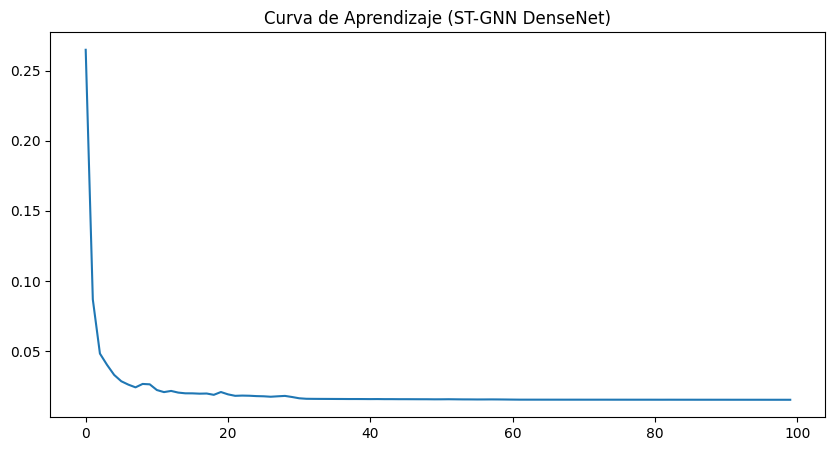

In [10]:

# --- ENTRENAMIENTO EFICIENTE (Gradient Accumulation) ---
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

# Configuración de Acumulación
PHYSICAL_BATCH_SIZE = 8   # Lo que cabe en GPU
TARGET_BATCH_SIZE = 32    # Lo que queremos matemáticamente
ACCUMULATION_STEPS = TARGET_BATCH_SIZE // PHYSICAL_BATCH_SIZE

print(f"Estrategia de Memoria: Batch Físico {PHYSICAL_BATCH_SIZE} | Acumulación {ACCUMULATION_STEPS} pasos | Batch Lógico {TARGET_BATCH_SIZE}")

scaler = GradScaler()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60], gamma=0.1)

print(f"Iniciando entrenamiento ST-GNN DenseNet en: {DEVICE}")
train_losses = []

model.train()
torch.backends.cudnn.benchmark = True 

optimizer.zero_grad() # Inicializar

for epoch in range(EPOCHS):
    epoch_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    
    for i, (x, t, y) in enumerate(pbar):
        x, t, y = x.to(DEVICE), t.to(DEVICE), y.to(DEVICE)
        
        # Mixed Precision
        with autocast():
            output = model(x, t, edge_index)
            loss = criterion(output, y)
            
            # Normalizar pérdida por acumulación
            loss = loss / ACCUMULATION_STEPS
        
        # Backward (acumula gradientes)
        scaler.scale(loss).backward()
        
        # Paso de optimización cada N pasos
        if (i + 1) % ACCUMULATION_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        # Recuperar valor real de pérdida para display
        epoch_loss += loss.item() * ACCUMULATION_STEPS
        pbar.set_postfix({'loss': f"{loss.item() * ACCUMULATION_STEPS:.5f}"})
    
    # Handle last batch if not divisible (Optional cleanup)
    if len(train_loader) % ACCUMULATION_STEPS != 0:
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    scheduler.step()
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.6f}")
    
    torch.cuda.empty_cache()

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Curva de Aprendizaje (ST-GNN DenseNet)')
plt.show()


## 5. Interpretación de Resultados

### 5.1. Métricas de Evaluación
Para evaluar el rendimiento, primero se **desnormalizan** las predicciones para volver a la escala original de tráfico (número de Internet).

$$ \hat{X}_{orig} = \hat{X}_{norm} \cdot (Max - Min) + Min $$

Se calculan las siguientes métricas:

1.  **RMSE (Root Mean Squared Error)**: Error cuadrático medio. Penaliza más los errores grandes.
    $$ RMSE = \sqrt{\frac{1}{M} \sum (\hat{x}_{orig} - x_{orig})^2} $$

2.  **MAE (Mean Absolute Error)**: Error absoluto medio. Es más robusto a outliers y fácil de interpretar (error promedio en Internet).
    $$ MAE = \frac{1}{M} \sum |\hat{x}_{orig} - x_{orig}| $$

3.  **R2 Score**: Coeficiente de determinación. Indica qué tan bien las predicciones se ajustan a los datos reales (1.0 es perfecto).

### 5.2. Visualización
*   **Scatter Plot**: Gráfico de dispersión de Predicción vs Realidad. Idealmente, los puntos deberían alinearse en la diagonal.
*   **Distribución de Errores**: Histograma de los residuos. Debería estar centrado en 0.
*   **Mapa de Calor de Error**: Muestra dónde se concentran los errores espacialmente.
*   **Serie Temporal**: Comparación visual de la predicción y la realidad a lo largo del tiempo para una celda específica.

Evaluando modelo...


Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 19.61it/s]



Resultados de Evaluación (ST-GNN):
RMSE: 57.5282
MAE:  23.4456
R2:   0.9761
WMAPE: 9.6715%
Accuracy: 90.3285%
Visualizando nodo con mayor tráfico: 5160


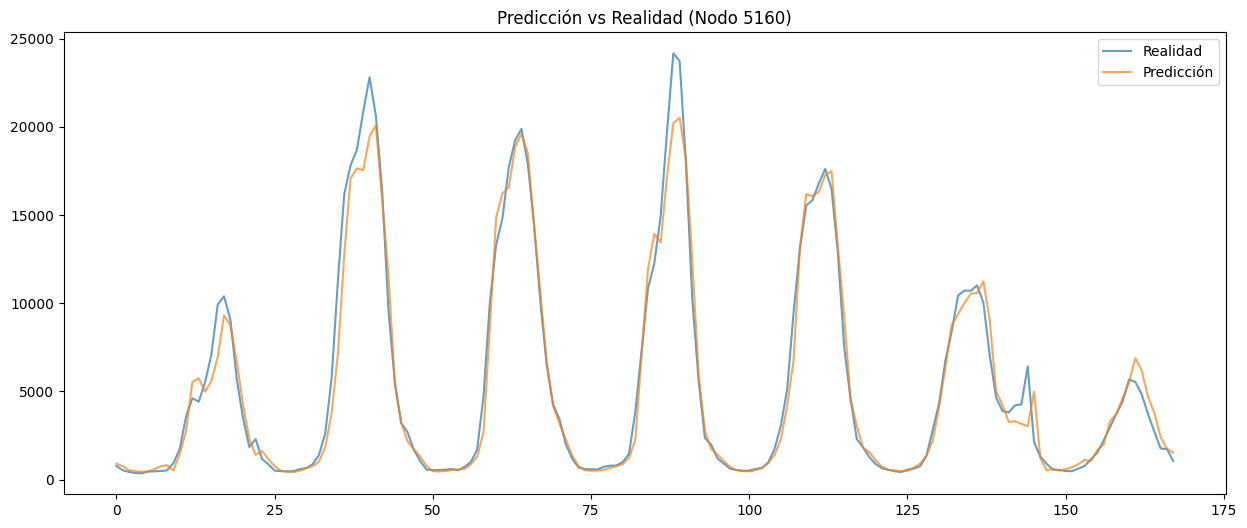

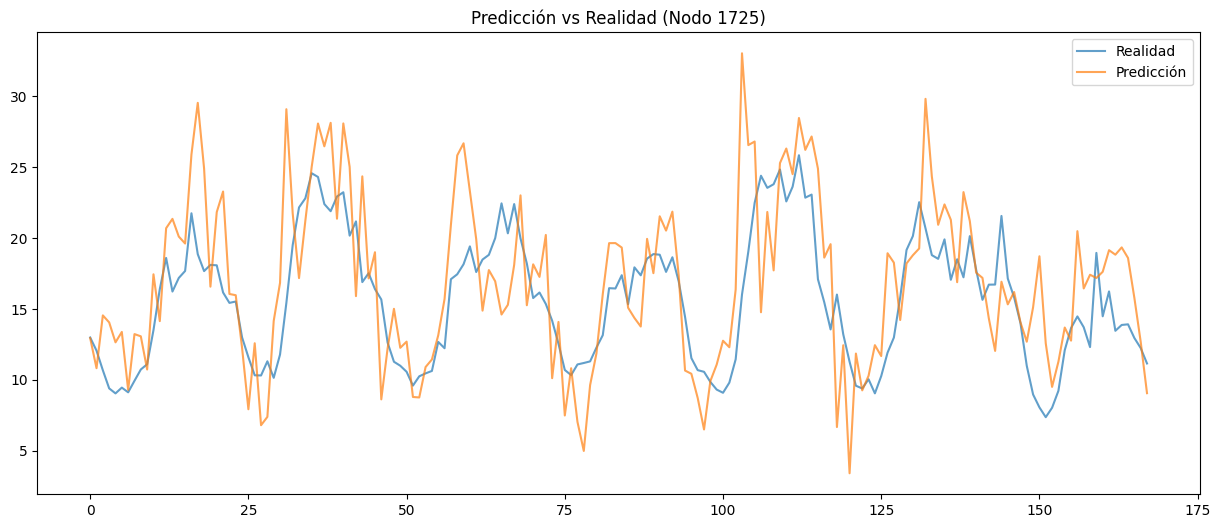

In [12]:
# --- EVALUACIÓN ---
model.eval()
predictions = []
ground_truth = []

print("Evaluando modelo...")
with torch.no_grad():
    for x, t, y in tqdm(test_loader, desc="Testing"):
        x, t, y = x.to(DEVICE), t.to(DEVICE), y.to(DEVICE)
        output = model(x, t, edge_index)
        predictions.append(output.cpu().numpy())
        ground_truth.append(y.cpu().numpy())

preds = np.concatenate(predictions, axis=0)
gt = np.concatenate(ground_truth, axis=0)

# Denormalize (Z-Score)
# x = (x_norm * std) + mean
preds_orig = preds * traffic_std + traffic_mean
gt_orig = gt * traffic_std + traffic_mean

# Avoid negative predictions
preds_orig = np.maximum(preds_orig, 0)

# Flatten for metrics
preds_flat = preds_orig.flatten()
gt_flat = gt_orig.flatten()

# Metrics
rmse = np.sqrt(mean_squared_error(gt_flat, preds_flat))
mae = mean_absolute_error(gt_flat, preds_flat)
r2 = r2_score(gt_flat, preds_flat)

# WMAPE
wmape = np.sum(np.abs(gt_flat - preds_flat)) / np.sum(np.abs(gt_flat))
accuracy = 1 - wmape

print("\nResultados de Evaluación (ST-GNN):")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R2:   {r2:.4f}")
print(f"WMAPE: {wmape:.4%}")
print(f"Accuracy: {accuracy:.4%}")

# --- VISUALIZACIÓN ---
# Validar en un nodo aleatorio con alto tráfico
# Encontrar nodo con max trafico promedio
mean_traffic_per_node = gt_orig.mean(axis=0).flatten()
max_node_idx = np.argmax(mean_traffic_per_node)
print(f"Visualizando nodo con mayor tráfico: {max_node_idx}")

plt.figure(figsize=(15, 6))
plt.plot(gt_orig[:, max_node_idx, 0], label='Realidad', alpha=0.7)
plt.plot(preds_orig[:, max_node_idx, 0], label='Predicción', alpha=0.7)
plt.title(f'Predicción vs Realidad (Nodo {max_node_idx})')
plt.legend()
plt.show()

# Random node
rand_node = np.random.randint(0, 10000)
plt.figure(figsize=(15, 6))
plt.plot(gt_orig[:, rand_node, 0], label='Realidad', alpha=0.7)
plt.plot(preds_orig[:, rand_node, 0], label='Predicción', alpha=0.7)
plt.title(f'Predicción vs Realidad (Nodo {rand_node})')
plt.legend()
plt.show()
             


## Interpretación de las Gráficas

### 1. Curva de Aprendizaje (Training Loss)
*   Muestra el **Error Cuadrático Medio (MSE)** en cada época.
*   Debe descender rápidamente al principio y estabilizarse.
*   Si la curva es plana desde el principio, indica problemas de aprendizaje (learning rate o gradientes).

### 2. Predicción vs Realidad (Nodo Max Tráfico)
*   Visualiza la serie temporal del **nodo con mayor carga promedio** de la red.
*   Es el "caso difícil" o crítico. Si el modelo predice bien aquí, es robusto.
*   **Azul**: Datos reales (Ground Truth).
*   **Naranja**: Predicción del modelo.

### 3. Grid de Celdas Aleatorias
*   Muestra 10 celdas elegidas al azar para verificar la generalización.
*   Permite ver si el modelo funciona bien en celdas con poco tráfico o patrones irregulares, no solo en las principales.
*   **Accuracy Local**: Se muestra la precisión (1 - WMAPE) específica para ese nodo en el título.



Resultados de Evaluación (ST-GNN):
RMSE: 57.5282
MAE:  23.4456
R2:   0.9761
WMAPE: 9.6715%
Accuracy: 90.3285%
Visualizando nodo con mayor tráfico: 5160


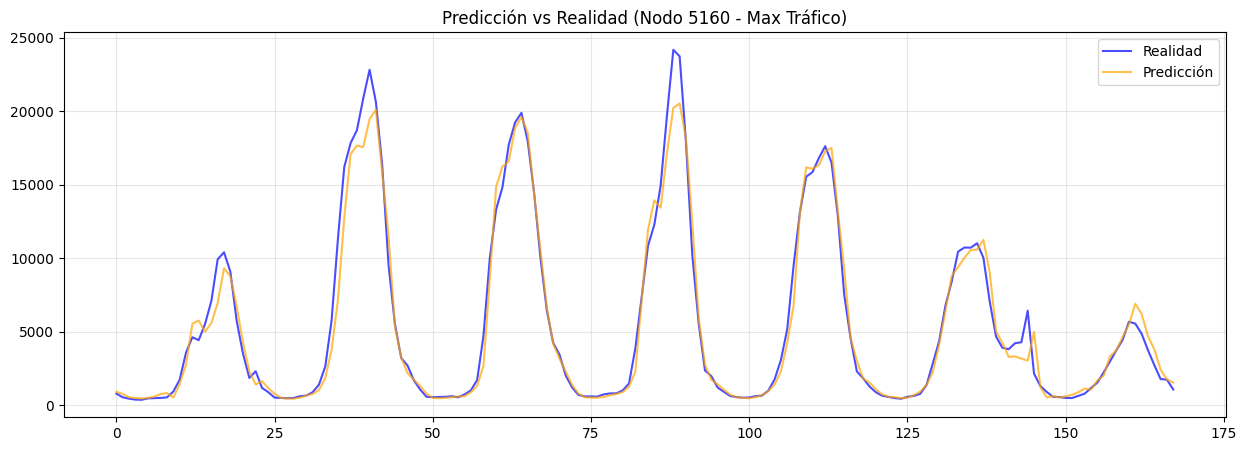

Visualizando 10 nodos aleatorios: [5628 8375 9785 7656  951 7392  709 6511 7691 6528]


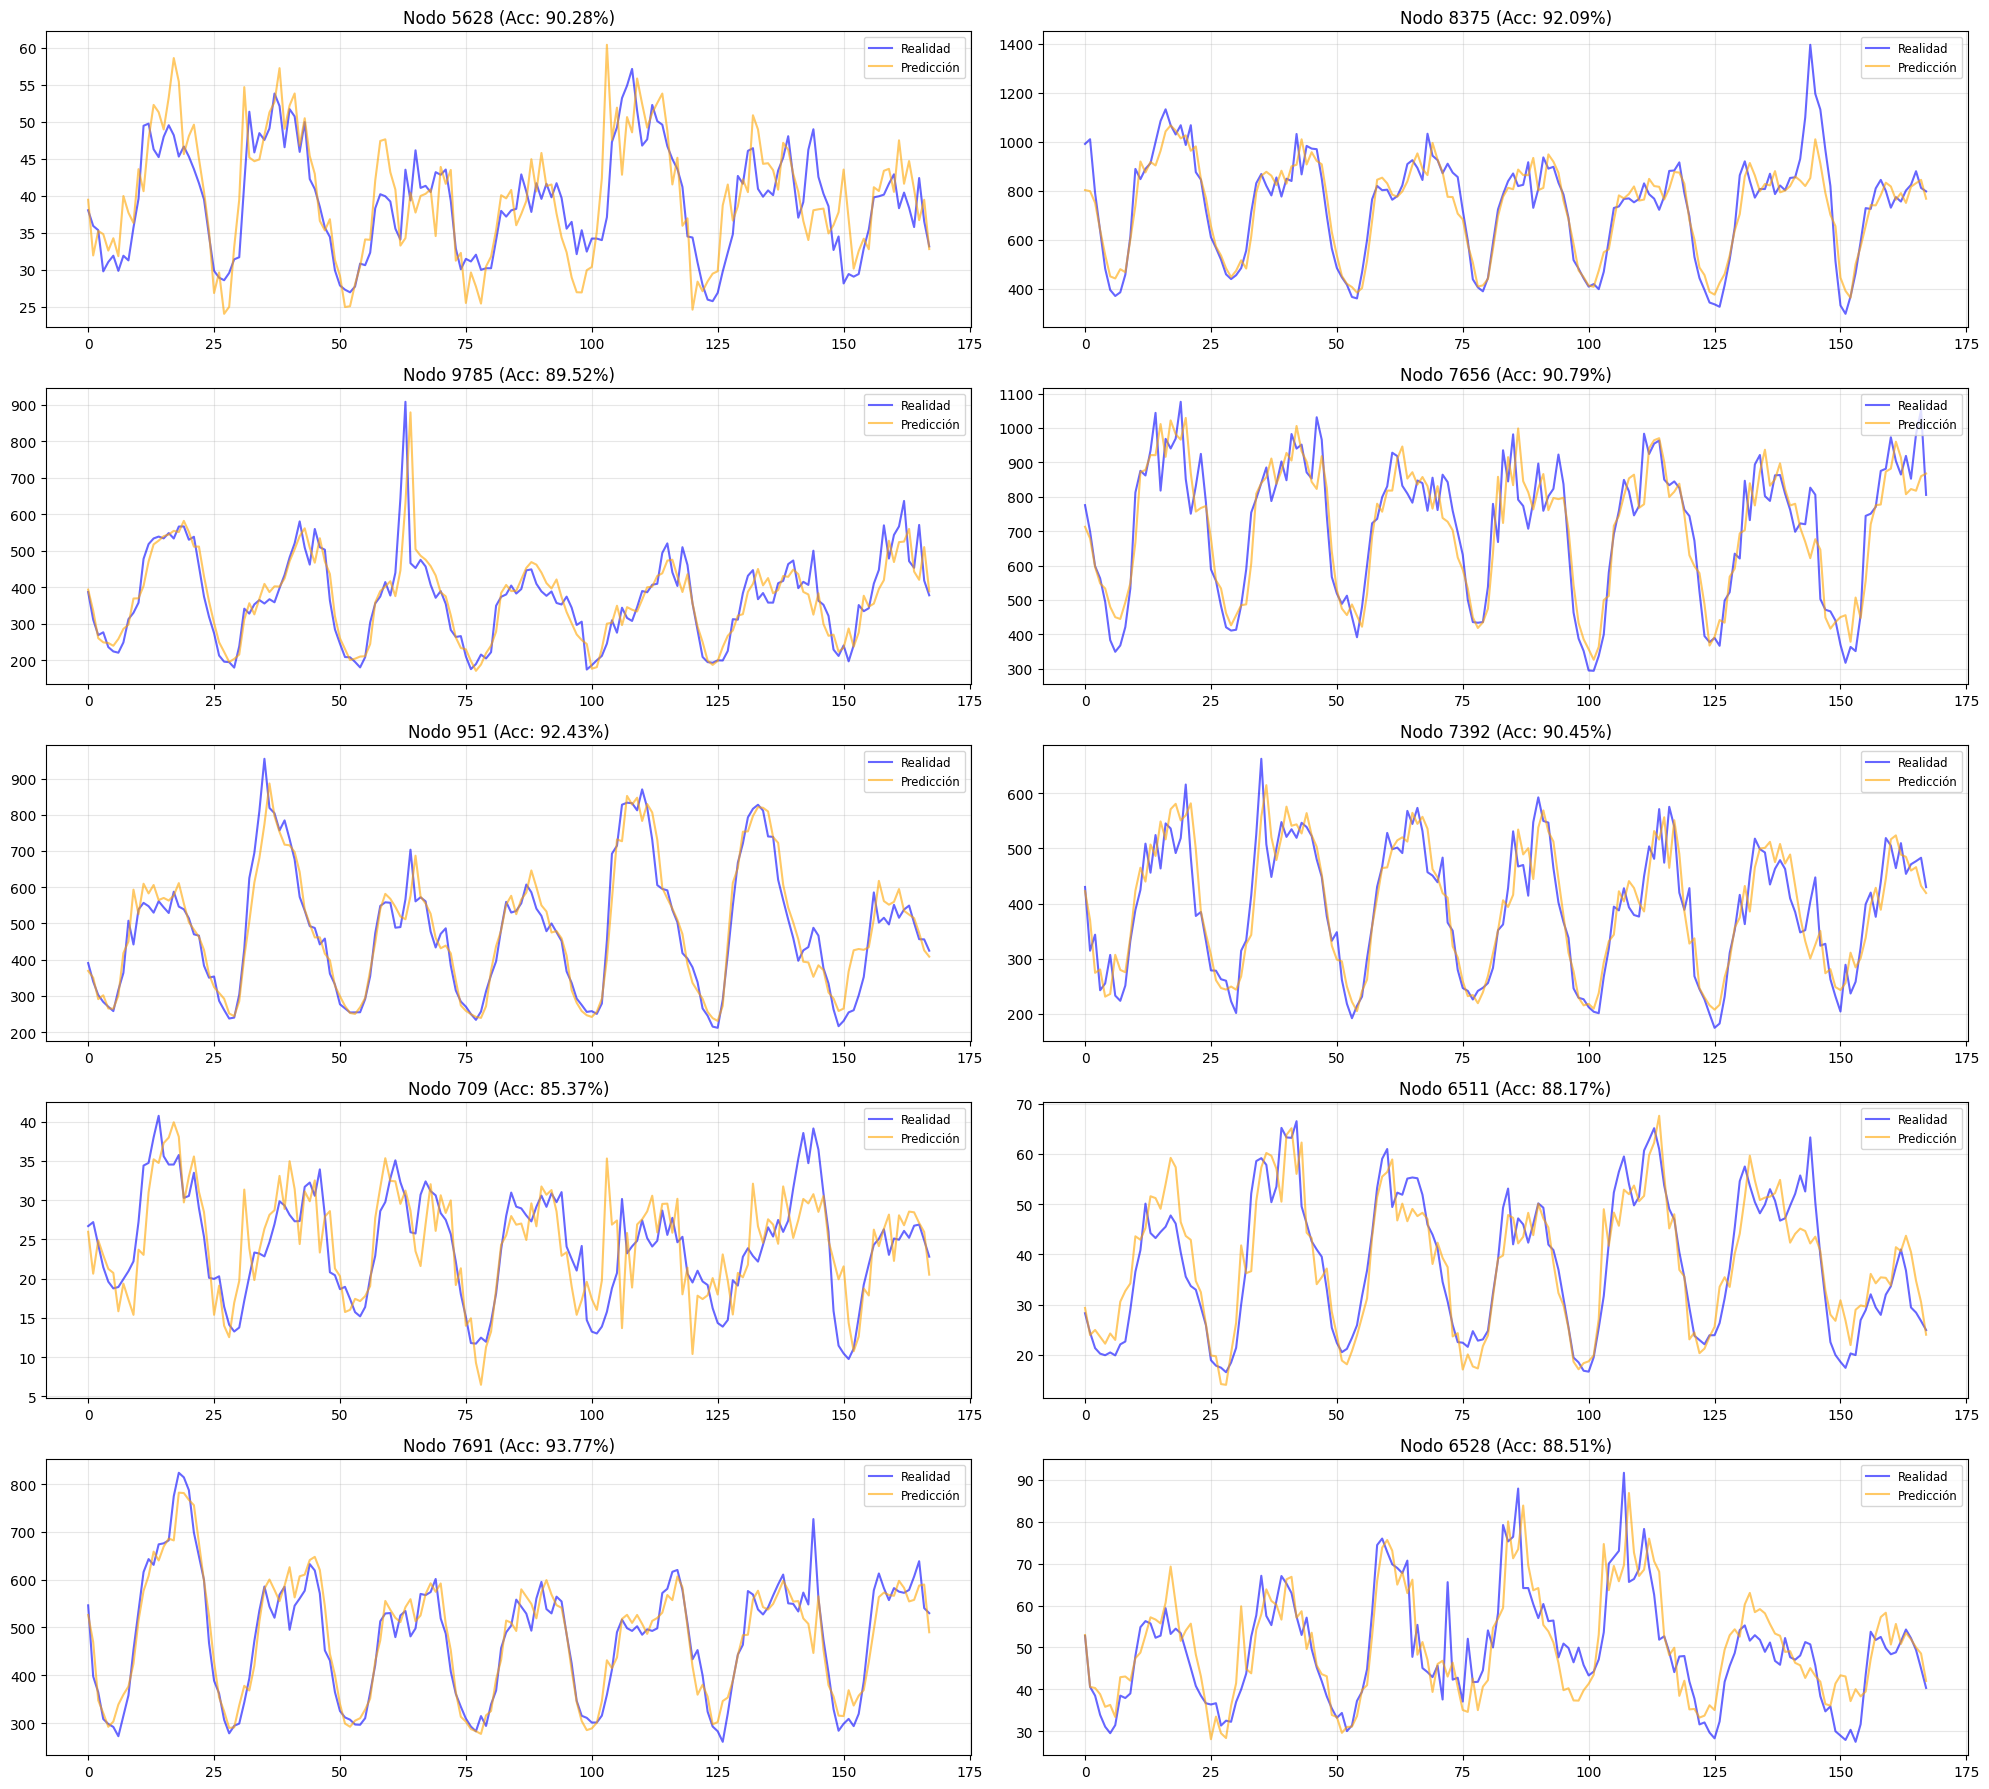

In [13]:
# ... (Tu código anterior de métricas: rmse, accuracy, etc.) ...
print("\nResultados de Evaluación (ST-GNN):")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R2:   {r2:.4f}")
print(f"WMAPE: {wmape:.4%}")
print(f"Accuracy: {accuracy:.4%}")
# --- VISUALIZACIÓN MEJORADA (10 Aleatorios) ---
import matplotlib.pyplot as plt
# 1. Nodo con mayor tráfico (Siempre es bueno mantener la referencia del "peor caso" de carga)
mean_traffic_per_node = gt_orig.mean(axis=0).flatten()
max_node_idx = np.argmax(mean_traffic_per_node)
print(f"Visualizando nodo con mayor tráfico: {max_node_idx}")
plt.figure(figsize=(15, 5))
plt.plot(gt_orig[:, max_node_idx, 0], label='Realidad', color='blue', alpha=0.7)
plt.plot(preds_orig[:, max_node_idx, 0], label='Predicción', color='orange', alpha=0.7)
plt.title(f'Predicción vs Realidad (Nodo {max_node_idx} - Max Tráfico)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# 2. Visualizar 10 Celdas Aleatorias
num_plots = 10
# Seleccionamos índices aleatorios (sin repetir)
random_indices = np.random.choice(gt_orig.shape[1], size=num_plots, replace=False)
print(f"Visualizando {num_plots} nodos aleatorios: {random_indices}")
# Creamos una figura grande con subplots (5 filas x 2 columnas)
fig, axes = plt.subplots(5, 2, figsize=(20, 18))
axes = axes.flatten()
for i, node_idx in enumerate(random_indices):
    ax = axes[i]
    ax.plot(gt_orig[:, node_idx, 0], label='Realidad', color='blue', alpha=0.6)
    ax.plot(preds_orig[:, node_idx, 0], label='Predicción', color='orange', alpha=0.6)
    
    # Métricas locales para este nodo (opcional, para ver qué tal va individualmente)
    local_acc = 1 - (np.sum(np.abs(gt_orig[:, node_idx] - preds_orig[:, node_idx])) / np.sum(np.abs(gt_orig[:, node_idx])))
    
    ax.set_title(f'Nodo {node_idx} (Acc: {local_acc:.2%})')
    ax.legend(loc='upper right', fontsize='small')
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()